# Tutorial BPMN+CPI API

In [21]:
import requests
import sys
sys.path.append('src')
from paco.parser.parse_tree import ParseTree
from paco.execution_tree.execution_tree import ExecutionTree
from paco.explainer.bdd.bdds import bdds_from_json

headers = {
	"Content-Type": "application/json",
}
url = "http://127.0.0.1:8000/"

# BPMN+CPI Grammar

This document explains the structure of BPMN+CPI

## Task
A **task** represents an atomic activity in the process.

Each task is identified by a name (e.g., `T0`, `T1`, etc.) and is described using:

- `impacts`: a **list of numeric values**, where each value represents a dimension of the impact, such as cost or time.
  - Example: `"T1": [4, 2]` means task T1 has an impact of 4 (e.g. cost) and 2 (e.g. hours).

- `durations`: a **list `[min_time, max_time]`** indicating the possible execution time window.
  - Example: `"T1": [0, 100]` means T1 can take between 0 and 100 time units.

## Choice
A **choice** is a point in the process where one of two branches can be selected.

Each choice is identified by a name (e.g., `C1`, `C2`) and has the following attributes:

- `name`: a unique label, used to reference the choice within the expression.
  - Example: `'C1'`

- `delay`: a **numeric value** representing the time it takes to make the choice.
  - Example: `"C1": 5` means there is a delay of 5 units before resolving choice C1.

## Nature
A **nature** is similar to a choice, but it is resolved by a probability rather than by a strategy.

- `name`: a unique label (e.g., `N1`), used to identify the nature point.
- `probability`: a **numeric value between 0 and 1** representing the probability of executing the **left** child.
  - Example: `"N1": 0.8` means the left branch is chosen with probability 0.8, and the right with 0.2.

## Expression Syntax Summary
- **Task**: named element, e.g. `T0`
- **Sequence**: use a comma `,` to denote sequential execution.
  - Example: `T0, T1` means T0 followed by T1.
- **Choice**: `(T1 / [C1] T2)` means either T1 or T2 is selected by choice C1.
- **Nature**: `(T1 ^ [N1] T2)` is governed by a probability (nature N1).
- **Parallel**: `(T1 || T2)` executes both T1 and T2 in parallel.
- Nesting is allowed for complex structures.


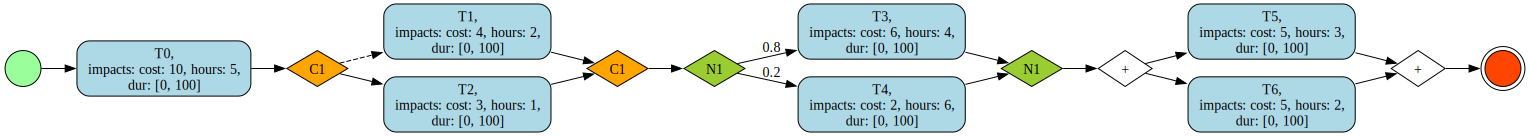

In [22]:
from utils.env import EXPRESSION, IMPACTS, DURATIONS, IMPACTS_NAMES, PROBABILITIES, DELAYS, NAMES, LOOP_PROBABILITY, LOOP_ROUND, H
import graphviz
from IPython.display import display, SVG

# A string that describing the full BPMN structure.
expression = "T0, (T1 / [C1] T2), (T3 ^ [N1] T4), (T5 || T6)"


bpmn = {
	EXPRESSION: expression,
	H: 0,
	# A dictionary mapping task names to impact vectors (e.g., cost and hours)
	IMPACTS: {"T0": [10, 5], "T1": [4, 2], "T2": [3, 1], "T3": [6, 4],
			  "T4": [2, 6], "T5": [5, 3], "T6": [5, 2]},
	# A dictionary mapping task names to [min_time, max_time] execution time
	DURATIONS: {"T0": [0, 100], "T1": [0, 100], "T2": [0, 100], "T3": [0, 100],
				"T4": [0, 100], "T5": [0, 100], "T6": [0, 100]},
	# A list of names corresponding to the dimensions of the impacts
	IMPACTS_NAMES: ["cost", "hours"],
	# A dictionary mapping nature labels to their execution probabilities for the left child.
	PROBABILITIES: {"N1": 0.8},
	# A dictionary mapping choice to their delay values.
	DELAYS: {"C1": 0},

	NAMES: {'C1':'C1', 'N1':'N1'},
	LOOP_PROBABILITY : {}, LOOP_ROUND: {}
}

try:
	resp = requests.get(f'{url}create_bpmn', json={'bpmn': bpmn},  headers=headers)
	resp.raise_for_status()
	display(SVG(graphviz.Source(resp.json()['bpmn_dot']).pipe(format="svg")))

except requests.exceptions.HTTPError as e:
	print(f"HTTP Error ({resp.status_code}):", resp.json())

## Region Tree (Parse Tree)

The **region tree**, also referred to as the **parse tree**, is a central concept used to represent the structural semantics of a BPMN+CPI process.

### Definition
The region tree is a **binary tree** constructed from a valid BPMN+CPI expression using a deterministic LALR(1) parser. It represents the recursive decomposition of the process into its syntactic subcomponents.

### Structure
- **Leaf nodes** are atomic **tasks**.
- **Internal nodes** represent composition operators:
  - `_ , _` for **sequential**
  - `_ / [ CHOICE ] _` for **choice**
  - `_ ^ [ NATURE ] _` for **nature (probabilistic)**
  - `_ || _` for **parallel**


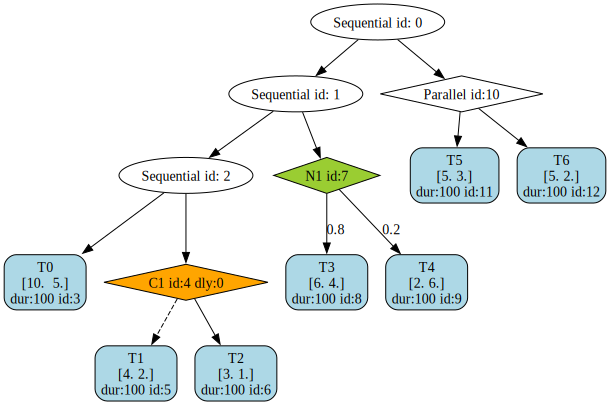

In [23]:
try:
	resp = requests.get(f'{url}create_parse_tree', json={"bpmn": bpmn},  headers=headers)
	resp.raise_for_status()

	response = resp.json()
	parse_tree, _,_ = ParseTree.from_json(response["parse_tree"], len(bpmn[IMPACTS_NAMES]), 0)
	dot = parse_tree.to_dot()

	display(SVG(graphviz.Source(dot).pipe(format="svg")))

except requests.exceptions.HTTPError as e:
	print(f"HTTP Error ({resp.status_code}):", resp.json())

## Execution Tree

The execution tree models all the possible executions of a BPMN+CPI process starting from its region tree.


- Each path from the root to a leaf represents a possible execution of the process.
- The accumulation of impacts (e.g., cost, hours) and execution durations along these paths.
- Leaves represent final outcomes of execution paths.

### Frontier Nodes

The frontier is a set of execution states that stay under the given bound.

These frontier nodes are highlighted in **light blue** in the visual representation of the execution tree.

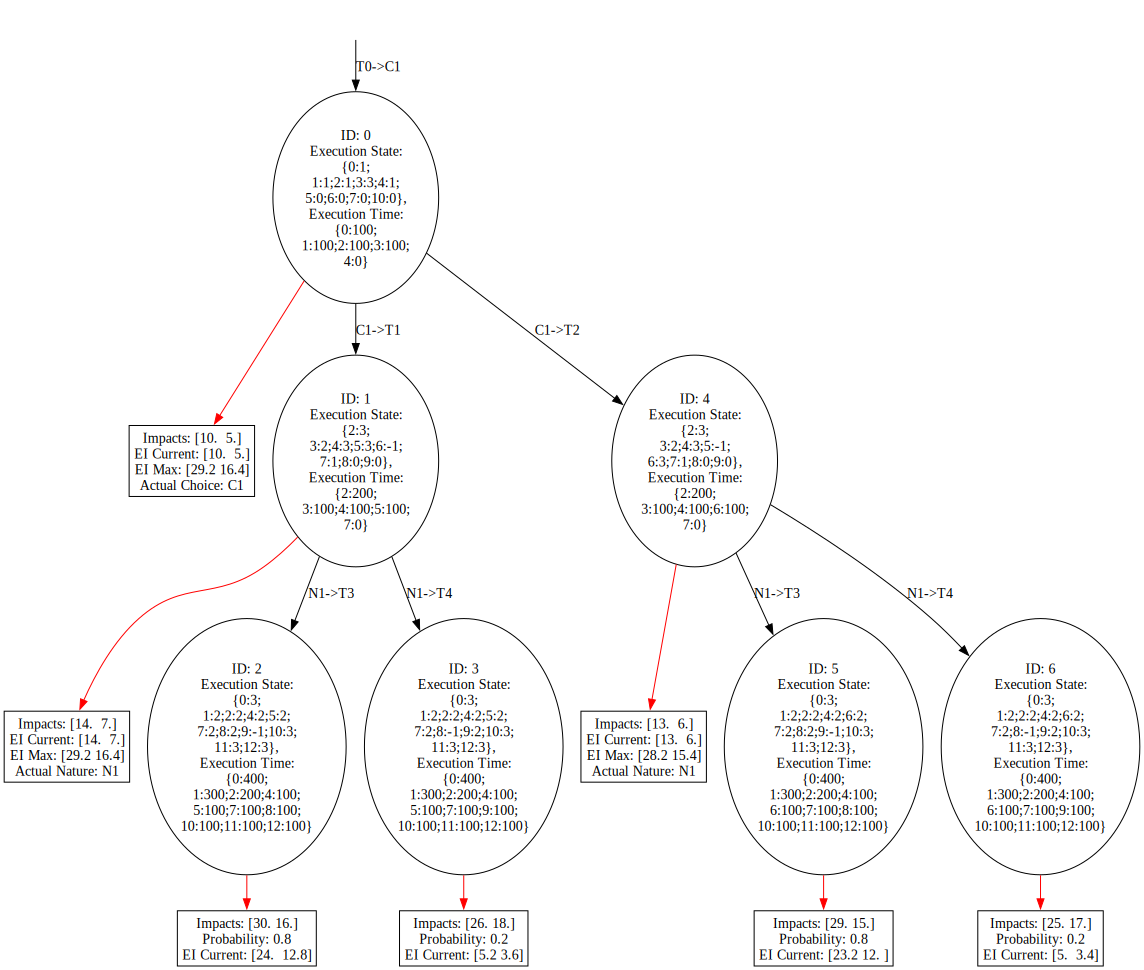

In [24]:
try:
	resp = requests.get(f'{url}create_execution_tree', json={"bpmn": bpmn},  headers=headers)
	resp.raise_for_status()

	response = resp.json()

	execution_tree = ExecutionTree.from_json(parse_tree, response["execution_tree"], bpmn["impacts_names"])
	dot = execution_tree.to_dot(state=True, executed_time=True, diff=True)
	display(SVG(graphviz.Source(dot).pipe(format="svg")))

except requests.exceptions.HTTPError as e:
	print(f"HTTP Error ({resp.status_code}):", resp.json())

## Find Strategies

Given a *bpmn*, *bound*, *parse_tree*, and *execution_tree* as input, the server can find strategies that satisfy the given bound.


This is the strategy, with an expected impact of: cost: 28.2 hours: 15.4


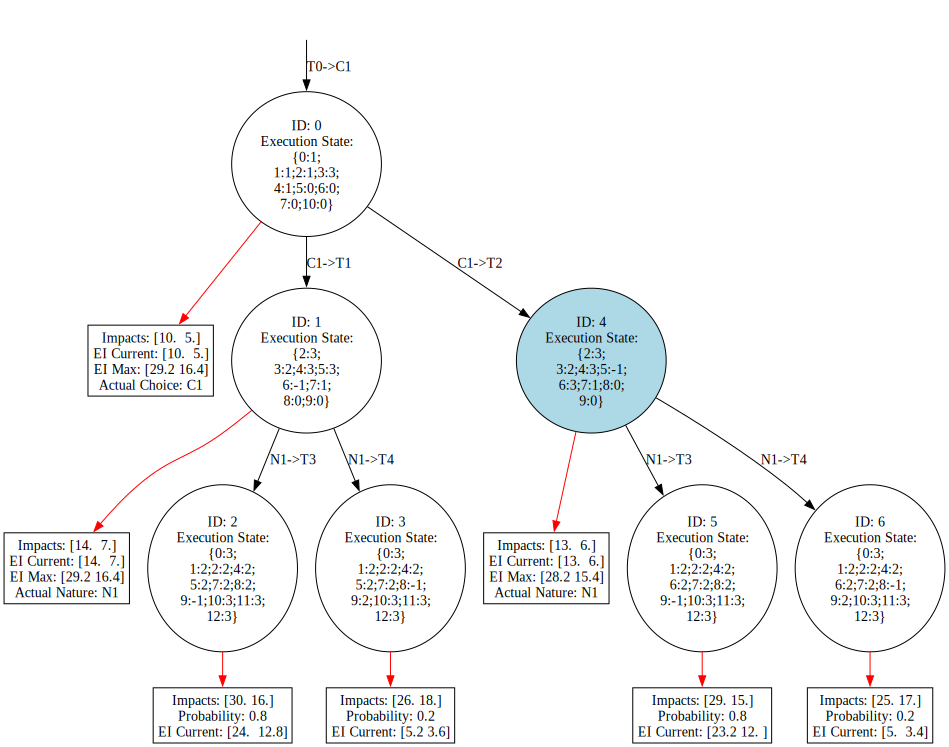

1 is dashed line of BPMN or Parse Tree


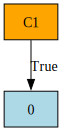

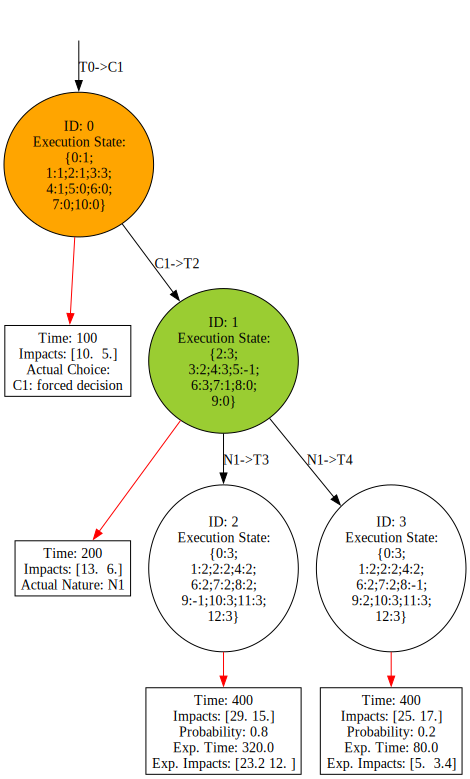

In [25]:
try:
	bound = [29.0, 16.0]

	resp = requests.get(f'{url}create_strategy', json={"bpmn": bpmn, "bound": bound, "parse_tree": parse_tree.to_dict(), "execution_tree": execution_tree.to_dict()}, headers=headers)
	resp.raise_for_status()

	response = resp.json()
	print(response["result"])

	frontier_solution_id = set()
	if "frontier_solution" in response: # Solution Found
		frontier_solution_id = set(map(int, response["frontier_solution"].strip("[]").split(",")))

	# With frontier node in light blue
	dot = execution_tree.to_dot(state=True, executed_time=False, diff=True, frontier=frontier_solution_id)
	display(SVG(graphviz.Source(dot).pipe(format="svg")))

	if "strategy_tree" in response:
		explained_choices = bdds_from_json(parse_tree, response["bdds"])
		print("1 is dashed line of BPMN or Parse Tree")
		for choice, bdd in explained_choices.items():
			svg_data = graphviz.Source(bdd.bdd_to_dot()).pipe(format="svg")
			display(SVG(svg_data))

		strategy_tree = ExecutionTree.from_json(parse_tree, response["strategy_tree"], bpmn["impacts_names"], explained_choices)

		#TREE_STATE
		dot = strategy_tree.to_dot(state=True, executed_time=False, diff=True)
		display(SVG(graphviz.Source(dot).pipe(format="svg")))

except requests.exceptions.HTTPError as e:
	print(f"HTTP Error ({resp.status_code}):", resp.json())